# Personality vs. Risk of Drug Use

<img src="https://i.imgur.com/RjwGlG1.jpeg" alt="Police dog typing a report" width="300" class="center"/>

In this notebook personality and illegal drug usage data are used to predict (monthly) drug users. The goal is to predict a person's illegal drug use with focus on recall rather than precision. During data preparation and model selection selected insights are highlighted. Analysis is performed according to the following structure:

1. Preparation
    - Import Modules
    - Settings
    - Import Data & Data Preparation
2. Exploratory Data Analysis
    - Overview
    - Target Variable
    - Heatmap
    - Features
    - Logistic Regression
4. Model Selection  
    - Unoptimized Models
        - Model 1 - Decision Tree
        - Model 2 - Support Vector Machine
        - Model 3 - AdaBoost Classifier
        - Model 4 - Random Forest
        - Model 5 - XGBoost Classifier
        - Model 6 - Logistic Regression
        - Model 7 - K-Nearest-Neighbors
    - Hyperparameter Tuning 
        - Model 2 - Support Vector Machine
        - Model 4 - Random Forest
        - Model 5 - XGBoost Classifier
        - Model 6 - Logistic Regression
    - Overview
5. Summary

## Preparation

### Import Modules

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import classification_report

# Import functions from Python-File (see visuals_script.py in Repo)
#import visuals_script as vs

### Settings

In [2]:
# Set random seed 
RSEED = 42

# Set pandas number format to two decimals
pd.set_option('float_format', '{:.2f}'.format)

# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
warnings.filterwarnings("ignore")

### Import Data & Data Preparation

In [3]:
# Read data
df = pd.read_csv('drug_consumption.csv', sep=";")

In [4]:
# Print data preview
df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,1,"0,49788","0,48246","-0,05921","0,96082","0,126","0,31287","-0,57545","-0,58331","-0,91699",...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,"-0,07854","-0,48246","1,98437","0,96082","-0,31685","-0,67825","1,93886","1,43533","0,76096",...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,"0,49788","-0,48246","-0,05921","0,96082","-0,31685","-0,46725","0,80523","-0,84732","-1,6209",...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,"-0,95197","0,48246","1,16365","0,96082","-0,31685","-0,14882","-0,80615","-0,01928","0,59042",...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,"0,49788","0,48246","1,98437","0,96082","-0,31685","0,73545","-1,6334","-0,45174","-0,30172",...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [5]:
# Print data meta data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1885 non-null   int64 
 1   Age        1885 non-null   object
 2   Gender     1885 non-null   object
 3   Education  1885 non-null   object
 4   Country    1885 non-null   object
 5   Ethnicity  1885 non-null   object
 6   Nscore     1885 non-null   object
 7   Escore     1885 non-null   object
 8   Oscore     1885 non-null   object
 9   Ascore     1885 non-null   object
 10  Cscore     1885 non-null   object
 11  Impulsive  1885 non-null   object
 12  SS         1885 non-null   object
 13  Alcohol    1885 non-null   object
 14  Amphet     1885 non-null   object
 15  Amyl       1885 non-null   object
 16  Benzos     1885 non-null   object
 17  Caff       1885 non-null   object
 18  Cannabis   1885 non-null   object
 19  Choc       1885 non-null   object
 20  Coke       1885 non-null   obj

After reading in our data we find that all except one variable are stored as data type object. The reason why all columns are recognized as objects rather than numbers is the wrong decimal separator "," instead of ".". We also find that some data (e.g. Country, Age) are not stored in a readable format.  

In [6]:
# Create list of falsely specified columns for numeric transformation
obj_cols = list(df.columns[df.dtypes==object])
cut = obj_cols.index('Alcohol')
convert = obj_cols[:cut]
for col in convert:
    df[col] = df[col].str.replace(',','.')
    df[col] = pd.to_numeric(df[col])

Replacing "," with "." and coverting the relevant columns to numeric format solves the issue with unsuitable data types.


In [7]:
repl_age = {-0.95197: '18-24', -0.07854: '25-34', 0.49788: '35-44', 
            1.09449: '45-54', 1.82213: '55-64', 2.59171: '65+'}
repl_gender = {0.48246: 'Female', -0.48246: 'Male'}
repl_educ = {-2.43591: 'Left school before 16 years', -1.73790: 'Left school at 16 years', 
             -1.43719: 'Left school at 17 years', -1.22751: 'Left school at 18 years', 
             -0.61113: 'Some college or university, no certificate or degree', 
             -0.05921: 'Professional certificate/ diploma', 0.45468: 'University degree',
             1.16365: 'Masters degree',	1.98437: 'Doctorate degree'}
repl_country = {-0.09765: 'Australia', 0.24923: 'Canada', -0.46841: 'New Zealand', 
                -0.28519: 'Other', 0.21128: 'Republic of Ireland', 
                0.96082: 'UK', -0.57009: 'USA'}
repl_ethnicity = {-0.50212: 'Asian', -1.10702: 'Black', 1.90725: 'Mixed-Black/Asian', 
                  0.12600: 'Mixed-White/Asian', -0.22166: 'Mixed-White/Black', 
                  0.11440: 'Other', -0.31685: 'White'}

In [8]:
df_label = df.replace({
    "Age": repl_age,
    "Gender": repl_gender,
    "Education": repl_educ,
    "Country": repl_country,
    "Ethnicity": repl_ethnicity
})

Next, we create dictionaries that hold the readable values from each column and replace the numerical values with the readable ones. For an overview/codebook check out [this link](http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29).

In [9]:
repl_drugs = {"CL0": 0, "CL1": 1, "CL2": 2, "CL3": 3, "CL4": 4 , "CL5": 5, "CL6": 6}
drug_cols = obj_cols[cut:]
#drug_cols

In [10]:
for col in drug_cols:
    df[col] = df[col].replace(repl_drugs)
    df[col] = pd.to_numeric(df[col])
    df_label[col] = df_label[col].replace(repl_drugs)
    df_label[col] = pd.to_numeric(df_label[col])

Drug consumption is classified into 7 categories: "CL0" - never used; "CL1" - used over a decade ago; "CL2" - used in last decade; "CL3" - used in last year; "CL4" - used in last month, "CL5" - used in last week, "CL6" - used in last day. We will recode those values to integers ranging from 0 to 6 where 0 stands for "never used" and 6 for "used last day". In other words we create an ordinarily scaled variable from the 7 given categories. 

In [11]:
legal = [
 'Alcohol',
 'Caff',
 'Choc',
 'Legalh',
 'Nicotine'
]

illegal = [ 
 'Amphet',
 'Amyl',
 'Benzos',
 'Cannabis',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'LSD',
 'Meth',
 'Shrooms',
 'Semer',
 'VSA'
]

#print((len(legal)+len(illegal)) == len(drug_cols))

Having a closer look at the 19 drugs respondents reported their usage on, we find that they stem from a very broad understanding of the term "drugs". Ranging from chocolate to crack it seems necessary to classify drugs into more meaningful groups. We choose to classify drugs into two groups - legal and illegal drugs. Our classification is based on current German law and considers all drugs that are not publicly available as illegal for recreational use. 

In [12]:
def recode_ever(row, cols):
    if any(row[cols] >= 1) :
      return 1
    else :
      return 0

def recode_decade(row, cols):
    if any(row[cols] >= 2) :
      return 1
    else :
      return 0

def recode_year(row, cols):
    if any(row[cols] >= 3) :
      return 1
    else :
      return 0

def recode_month(row, cols):
    if any(row[cols] >= 4) :
      return 1
    else :
      return 0

def recode_week(row, cols):
    if any(row[cols] >= 5) :
      return 1
    else :
      return 0

def recode_day(row, cols):
    if any(row[cols] >= 6) :
      return 1
    else :
      return 0

df['used_illegal_ever'] = df.apply (lambda row: recode_ever(row, illegal), axis=1)
df['used_legal_ever'] = df.apply (lambda row: recode_ever(row, legal), axis=1)
df['used_illegal_dec'] = df.apply (lambda row: recode_decade(row, illegal), axis=1)
df['used_legal_dec'] = df.apply (lambda row: recode_decade(row, legal), axis=1)
df['used_illegal_year'] = df.apply (lambda row: recode_year(row, illegal), axis=1)
df['used_legal_year'] = df.apply (lambda row: recode_year(row, legal), axis=1)
df['used_illegal_month'] = df.apply (lambda row: recode_month(row, illegal), axis=1)
df['used_legal_month'] = df.apply (lambda row: recode_month(row, legal), axis=1)
df['used_illegal_week'] = df.apply (lambda row: recode_week(row, illegal), axis=1)
df['used_legal_week'] = df.apply (lambda row: recode_week(row, legal), axis=1)
df['used_illegal_day'] = df.apply (lambda row: recode_day(row, illegal), axis=1)
df['used_legal_day'] = df.apply (lambda row: recode_day(row, legal), axis=1)

usage = df.columns[-12:]
#usage

In order to train our machine learning models we need a single target variable for prediction. We achieve this by summing up the information in all illegal drug columns by flagging rows that have certain values in at least one column. In this fashion we extract the frequency for last consumption of at least one illegal drug. In other words, the created columns that flag non-users in a certain interval with 0 and drug users in the same interval with 1.

In [13]:
df[usage].describe()

,used_illegal_ever,used_legal_ever,used_illegal_dec,used_legal_dec,used_illegal_year,used_legal_year,used_illegal_month,used_legal_month,used_illegal_week,used_legal_week,used_illegal_day,used_legal_day
count,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00
mean,0.84,1.00,0.75,1.00,0.62,1.00,0.52,1.00,0.45,0.99,0.33,0.89
std,0.37,0.02,0.43,0.04,0.48,0.04,0.50,0.06,0.50,0.11,0.47,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
50%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


After creating 12 columns with drug usage data we check their distribution. Regarding data balance the "used_illegal_month" seems like a sweet spot as it delivers a 50/50 distribution for our prediction target. Also, from a substantial perspective we are somewhere in the middle classifying a person who used an illegal drug in the past month, week, or day as a user. Consequently, if most recent consumption of an illegal drug is more than a month away we would classify this person as a non-user. 

In [14]:
#df_drugs = df[drug_cols]
#df_drugs.sample(5)

In [15]:
df_label['used_illegal_month'] = df['used_illegal_month']
df_label['used_illegal_month'] = df_label['used_illegal_month'].astype('category')

We transfer the "used_illegal_month" 

In [16]:
df_label.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA,used_illegal_month
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,0.31,-0.58,-0.58,-0.92,...,0,0,0,0,0,0,2,0,0,0
1,2,25-34,Male,Doctorate degree,UK,White,-0.68,1.94,1.44,0.76,...,0,2,0,2,3,0,4,0,0,1
2,3,35-44,Male,Professional certificate/ diploma,UK,White,-0.47,0.81,-0.85,-1.62,...,0,0,0,0,0,1,0,0,0,0
3,4,18-24,Female,Masters degree,UK,White,-0.15,-0.81,-0.02,0.59,...,0,2,0,0,0,0,2,0,0,0
4,5,35-44,Female,Doctorate degree,UK,White,0.74,-1.63,-0.45,-0.30,...,0,0,1,0,0,2,2,0,0,0


In [17]:
df_model = df.drop(drug_cols, axis=1)
df_model = df_model.drop("ID", axis=1)
df_model = df_model.drop(["used_illegal_ever", "used_legal_ever", "used_illegal_dec", "used_legal_dec", "used_illegal_year", "used_legal_year", "used_legal_month", "used_illegal_week", "used_legal_week", "used_illegal_day", "used_legal_day"], axis=1)

In [108]:
# Before we go on let's split the data into features and target label
df_model.shape
features = df_model.iloc[:,0:12]
target = df_model.iloc[:,12]
features.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,0.50,0.48,-0.06,0.96,0.13,0.31,-0.58,-0.58,-0.92,-0.01,-0.22,-1.18
1,-0.08,-0.48,1.98,0.96,-0.32,-0.68,1.94,1.44,0.76,-0.14,-0.71,-0.22
2,0.50,-0.48,-0.06,0.96,-0.32,-0.47,0.81,-0.85,-1.62,-1.01,-1.38,0.40
3,-0.95,0.48,1.16,0.96,-0.32,-0.15,-0.81,-0.02,0.59,0.58,-1.38,-1.18
4,0.50,0.48,1.98,0.96,-0.32,0.74,-1.63,-0.45,-0.30,1.31,-0.22,-0.22


In [19]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1885 non-null   float64
 1   Gender              1885 non-null   float64
 2   Education           1885 non-null   float64
 3   Country             1885 non-null   float64
 4   Ethnicity           1885 non-null   float64
 5   Nscore              1885 non-null   float64
 6   Escore              1885 non-null   float64
 7   Oscore              1885 non-null   float64
 8   Ascore              1885 non-null   float64
 9   Cscore              1885 non-null   float64
 10  Impulsive           1885 non-null   float64
 11  SS                  1885 non-null   float64
 12  used_illegal_month  1885 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 191.6 KB


In [20]:
df_model = df_model.astype({"Age": "category", "Gender": "category", "Education": "category", "Country": "category", "Ethnicity": "category", "used_illegal_month": "category"})

In [105]:
df_model = df_model.astype({"used_illegal_month": "int"})
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 1885 non-null   category
 1   Gender              1885 non-null   category
 2   Education           1885 non-null   category
 3   Country             1885 non-null   category
 4   Ethnicity           1885 non-null   category
 5   Nscore              1885 non-null   float64 
 6   Escore              1885 non-null   float64 
 7   Oscore              1885 non-null   float64 
 8   Ascore              1885 non-null   float64 
 9   Cscore              1885 non-null   float64 
 10  Impulsive           1885 non-null   float64 
 11  SS                  1885 non-null   float64 
 12  used_illegal_month  1885 non-null   int64   
dtypes: category(5), float64(7), int64(1)
memory usage: 128.5 KB


In [106]:
cat_features = list(features.columns[features.dtypes=='category'])

# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features, columns=cat_features, drop_first=True)

# Print the number of features after one-hot encoding
print(features.shape[1])

12


In [23]:
features.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,0.50,0.48,-0.06,0.96,0.13,0.31,-0.58,-0.58,-0.92,-0.01,-0.22,-1.18
1,-0.08,-0.48,1.98,0.96,-0.32,-0.68,1.94,1.44,0.76,-0.14,-0.71,-0.22
2,0.50,-0.48,-0.06,0.96,-0.32,-0.47,0.81,-0.85,-1.62,-1.01,-1.38,0.40
3,-0.95,0.48,1.16,0.96,-0.32,-0.15,-0.81,-0.02,0.59,0.58,-1.38,-1.18
4,0.50,0.48,1.98,0.96,-0.32,0.74,-1.63,-0.45,-0.30,1.31,-0.22,-0.22


## Exploratory Data Analysis

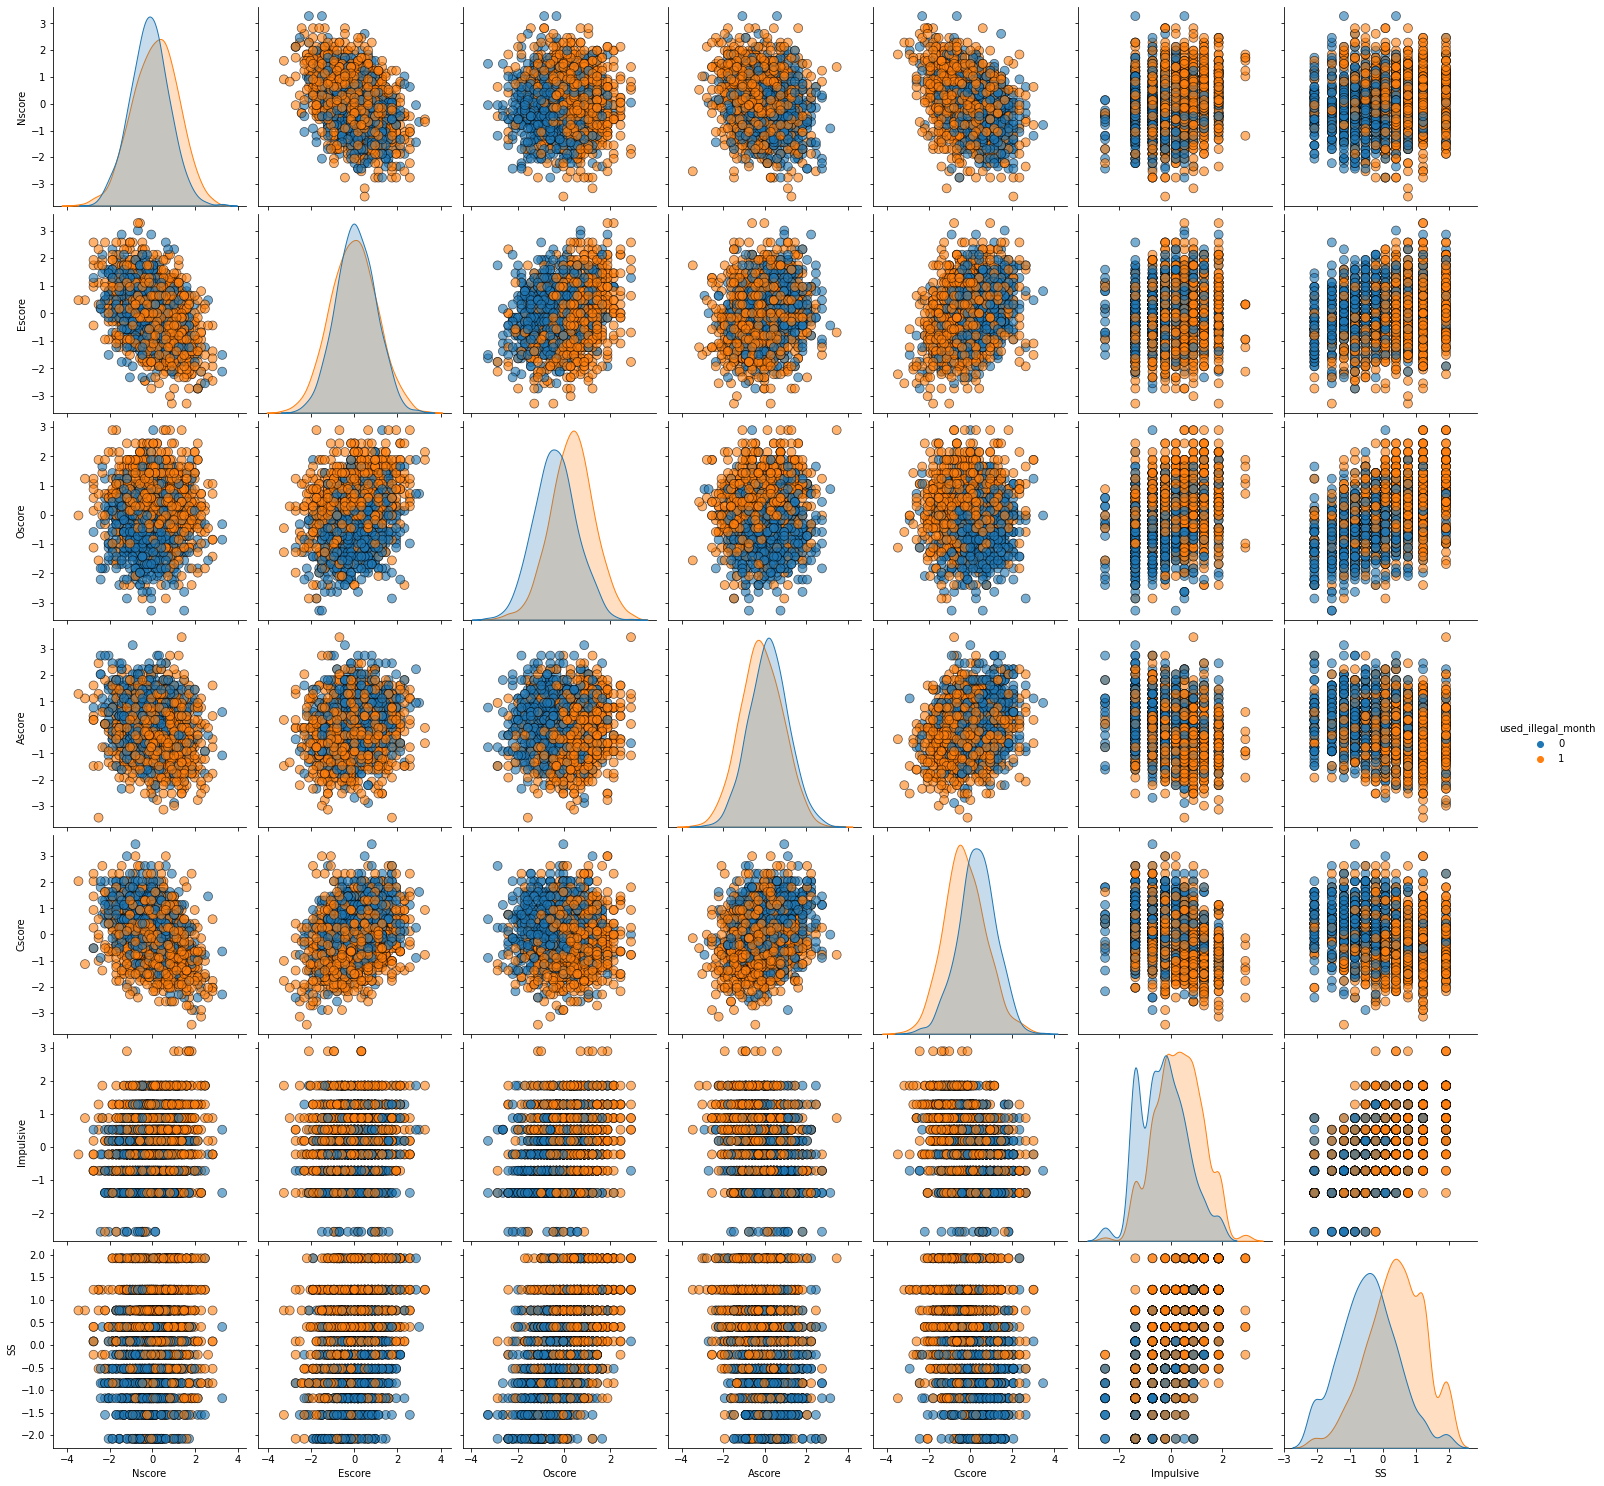

In [24]:
sns.pairplot(df_label, vars=["Nscore", "Escore", 
                            "Oscore", "Ascore", 
                            "Cscore", "Impulsive",
                            "SS"], 
             hue='used_illegal_month', diag_kind="kde", 
             plot_kws = {'alpha': 0.6, 
                         's': 80, 'edgecolor': 'k'},
             height = 3);

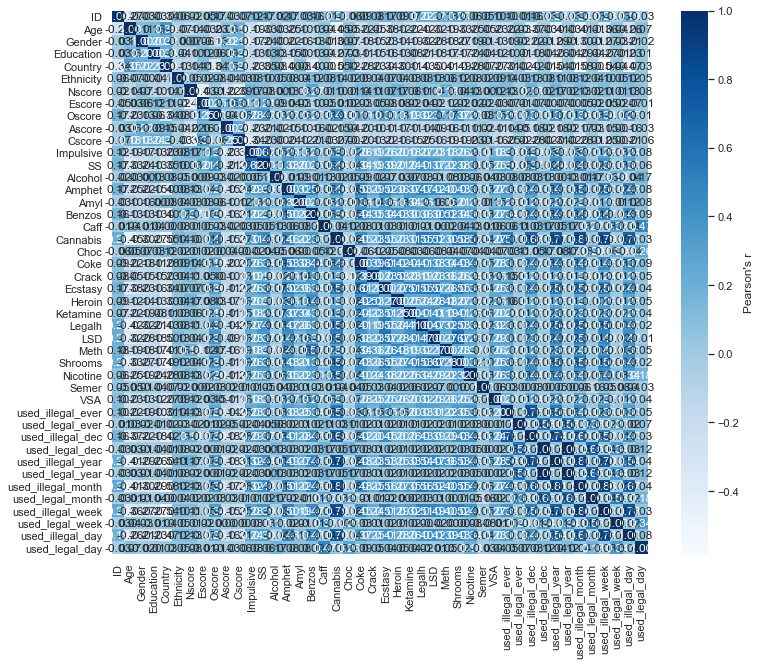

In [25]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(12,10),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
heat_map = sns.heatmap(df.corr(), cmap='Blues', 
                       annot=True, fmt='.2f' ,
                       cbar_kws={'label': "Pearson's r",
                                 'orientation': 'vertical'})
heat_map.set_xticklabels(heat_map.get_xticklabels(),
                         rotation=90);

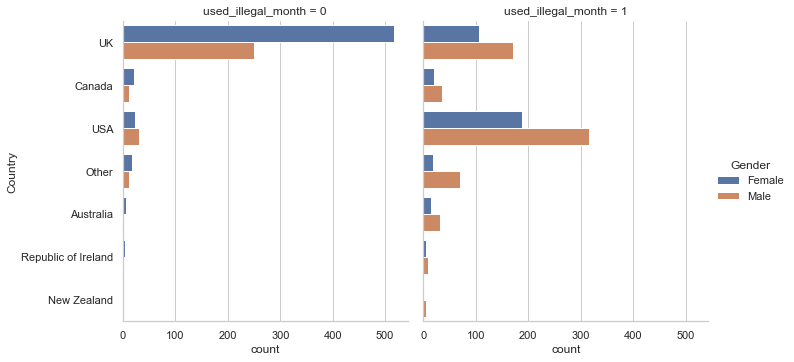

In [26]:
sns.catplot(y='Country', hue='Gender', col='used_illegal_month', data=df_label, kind='count');

In [27]:
df[drug_cols].sum().sort_values(ascending=False)

Caff        10337
Choc         9626
Alcohol      8737
Nicotine     6033
Cannabis     5635
Benzos       2762
Legalh       2556
Amphet       2527
Ecstasy      2477
Shrooms      2238
Coke         2189
LSD          2001
Meth         1558
Amyl         1144
Ketamine     1073
VSA           817
Heroin        705
Crack         561
Semer          18
dtype: int64

In [28]:
df[usage].describe()

,used_illegal_ever,used_legal_ever,used_illegal_dec,used_legal_dec,used_illegal_year,used_legal_year,used_illegal_month,used_legal_month,used_illegal_week,used_legal_week,used_illegal_day,used_legal_day
count,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00
mean,0.84,1.00,0.75,1.00,0.62,1.00,0.52,1.00,0.45,0.99,0.33,0.89
std,0.37,0.02,0.43,0.04,0.48,0.04,0.50,0.06,0.50,0.11,0.47,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
50%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [29]:
df_label['Country'].unique()

array(['UK', 'Canada', 'USA', 'Other', 'Australia', 'Republic of Ireland',
       'New Zealand'], dtype=object)

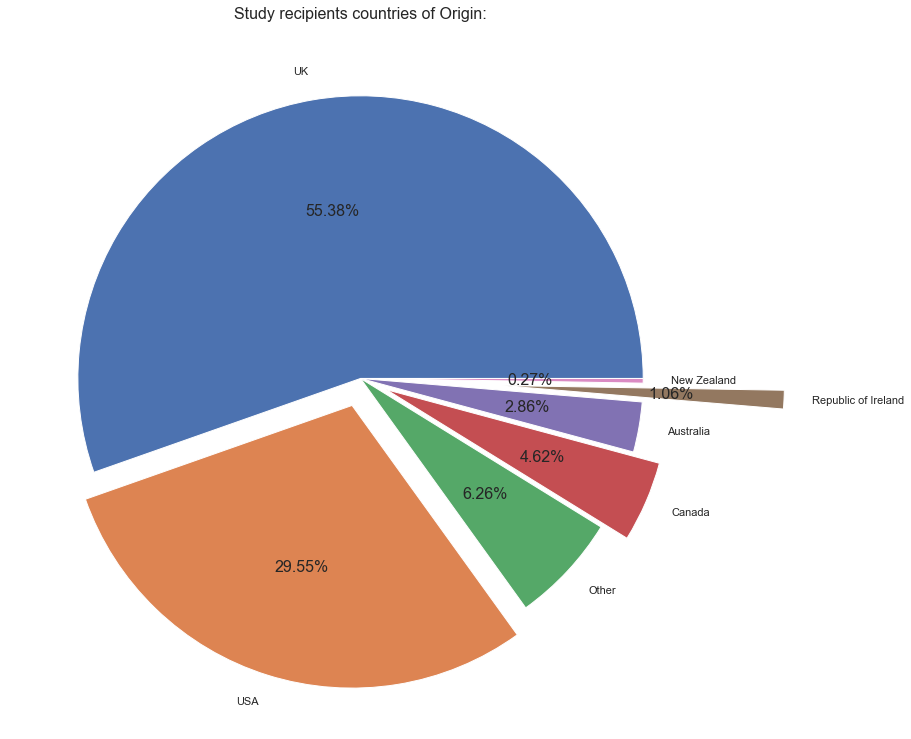

In [30]:
plt.figure(figsize=(13,13));
plt.rcParams.update({'font.size':16})
x = df_label["Country"].value_counts()
labels= x.index.to_list()
plt.title('Study recipients countries of Origin:')
plt.pie(x,explode=(0,0.1,0,0.1,0,0.5,0),labels=labels, autopct='%1.2f%%')
#plt.savefig('pictures/Study_recipients_countries_of_Origin.png', transparent=True)
plt.show()

In [31]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(17,12),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
heat_map = sns.heatmap(df_drugs[illegal].corr(), cmap='Blues', 
                       annot=True, fmt='.2f' ,
                       cbar_kws={'label': "Pearson's r",
                                 'orientation': 'vertical'})
heat_map.set_xticklabels(heat_map.get_xticklabels(),
                         rotation=90);

NameError: name 'df_drugs' is not defined

### Logistic Regression

In [32]:
f_n = 'used_illegal_month ~ Age + Gender + Education + Country + Ethnicity + Nscore + Escore + Oscore + Ascore + Cscore + Impulsive + SS'
result = smf.logit(formula=f_n, data=df_model).fit(method='bfgs', maxiter=1000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.383171
         Iterations: 261
         Function evaluations: 262
         Gradient evaluations: 262


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     used_illegal_month   No. Observations:                 1885
Model:                          Logit   Df Residuals:                     1851
Method:                           MLE   Df Model:                           33
Date:                Fri, 09 Jul 2021   Pseudo R-squ.:                  0.4464
Time:                        13:18:21   Log-Likelihood:                -722.28
converged:                       True   LL-Null:                       -1304.7
Covariance Type:            nonrobust   LLR p-value:                1.697e-223
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.6155      0.846      3.090      0.002       0.957       4.274
Age[T.-0.07854]          -0.9586      0.189     -5.060      0.000      -1.330      -0.587
Age[T.0.49788]           -1.3714      0.202     -6.774      0.000      -1.768      -0.975
Age[T.1.09449]           -1.5549      0.221     -7.046      0.000      -1.987      -1.122
Age[T.1.82213]           -1.7605      0.315     -5.586      0.000      -2.378      -1.143
Age[T.2.59171]           -1.8521      0.727     -2.549      0.011      -3.276      -0.428
Gender[T.0.48246]        -0.7019      0.144     -4.889      0.000      -0.983      -0.421
Education[T.-1.7379]      0.3144      0.587      0.535      0.592      -0.837       1.466
Education[T.-1.43719]     0.3436      0.764      0.450      0.653      -1.154       1.841
Education[T.-1.22751]     0.0411      0.614      0.067      0.947      -1.162       1.244
Education[T.-0.61113]    -0.2582      0.553     -0.467      0.640      -1.341       0.825
Education[T.-0.05921]    -0.2458      0.554     -0.443      0.657      -1.332       0.840
Education[T.0.45468]     -1.0207      0.545     -1.873      0.061      -2.089       0.048
Education[T.1.16365]     -1.1447      0.557     -2.055      0.040      -2.236      -0.053
Education[T.1.98437]     -0.7717      0.604     -1.278      0.201      -1.955       0.412
Country[T.-0.46841]      -0.3477      1.299     -0.268      0.789      -2.894       2.198
Country[T.-0.28519]      -1.2563      0.297     -4.234      0.000      -1.838      -0.675
Country[T.-0.09765]       0.1822      0.468      0.389      0.697      -0.735       1.100
Country[T.0.21128]       -1.3938      0.606     -2.300      0.021      -2.582      -0.206
Country[T.0.24923]       -1.1211      0.333     -3.366      0.001      -1.774      -0.468
Country[T.0.96082]       -2.3471      0.186    -12.602      0.000      -2.712      -1.982
Ethnicity[T.-0.50212]    -0.1934      0.892     -0.217      0.828      -1.942       1.555
Ethnicity[T.-0.31685]     0.9201      0.638      1.443      0.149      -0.330       2.170
Ethnicity[T.-0.22166]     1.8375      0.911      2.018      0.044       0.053       3.622
Ethnicity[T.0.1144]       1.2302      0.761      1.617      0.106      -0.261       2.721
Ethnicity[T.0.126]        0.9631      0.962      1.002      0.317      -0.922       2.848
Ethnicity[T.1.90725]      6.6292     32.734      0.203      0.840     -57.528      70.786
Nscore                   -0.0250      0.083     -0.301      0.763      -0.188       0.138
Escore                   -0.1263      0.088     -1.436      0.151      -0.299       0.046
Oscore                    0.5264      0.083      6.316      0.000       0.363       0.690
Ascore                   -0.0780      0.074     -1.050      0.294      -0.223       0.068
Cscore                   -0.2507      0.083     -3.024      0.002      -0.413      -0.088
Impulsive                 0.0804      0.094      0.857      0.392      -0.104       0.264
S

In [33]:
np.exp(result.params)

Intercept                13.67
Age[T.-0.07854]           0.38
Age[T.0.49788]            0.25
Age[T.1.09449]            0.21
Age[T.1.82213]            0.17
Age[T.2.59171]            0.16
Gender[T.0.48246]         0.50
Education[T.-1.7379]      1.37
Education[T.-1.43719]     1.41
Education[T.-1.22751]     1.04
Education[T.-0.61113]     0.77
Education[T.-0.05921]     0.78
Education[T.0.45468]      0.36
Education[T.1.16365]      0.32
Education[T.1.98437]      0.46
Country[T.-0.46841]       0.71
Country[T.-0.28519]       0.28
Country[T.-0.09765]       1.20
Country[T.0.21128]        0.25
Country[T.0.24923]        0.33
Country[T.0.96082]        0.10
Ethnicity[T.-0.50212]     0.82
Ethnicity[T.-0.31685]     2.51
Ethnicity[T.-0.22166]     6.28
Ethnicity[T.0.1144]       3.42
Ethnicity[T.0.126]        2.62
Ethnicity[T.1.90725]    756.90
Nscore                    0.98
Escore                    0.88
Oscore                    1.69
Ascore                    0.93
Cscore                    0.78
Impulsiv

## Model Selection

### Train-Test-Split

In [110]:
features = features.astype({"Age": "category", "Gender": "category", "Education": "category", "Country": "category", "Ethnicity": "category"})
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Age        1885 non-null   category
 1   Gender     1885 non-null   category
 2   Education  1885 non-null   category
 3   Country    1885 non-null   category
 4   Ethnicity  1885 non-null   category
 5   Nscore     1885 non-null   float64 
 6   Escore     1885 non-null   float64 
 7   Oscore     1885 non-null   float64 
 8   Ascore     1885 non-null   float64 
 9   Cscore     1885 non-null   float64 
 10  Impulsive  1885 non-null   float64 
 11  SS         1885 non-null   float64 
dtypes: category(5), float64(7)
memory usage: 113.8 KB


In [111]:
cat_features = list(features.columns[features.dtypes=='category'])

# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features, columns=cat_features, drop_first=True)

features.head()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Age_-0.07854,Age_0.49788,Age_1.09449,...,Country_-0.09765,Country_0.21128,Country_0.24923,Country_0.96082,Ethnicity_-0.50212,Ethnicity_-0.31685,Ethnicity_-0.22166,Ethnicity_0.1144,Ethnicity_0.126,Ethnicity_1.90725
0,0.31,-0.58,-0.58,-0.92,-0.01,-0.22,-1.18,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,-0.68,1.94,1.44,0.76,-0.14,-0.71,-0.22,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,-0.47,0.81,-0.85,-1.62,-1.01,-1.38,0.40,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,-0.15,-0.81,-0.02,0.59,0.58,-1.38,-1.18,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0.74,-1.63,-0.45,-0.30,1.31,-0.22,-0.22,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [112]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, 
                                                    random_state=RSEED, stratify=target) 
# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1319 samples.
Testing set has 566 samples.


In [144]:
# Initialize a scaler, then apply it to the features
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
# Show an example of a record with scaling applied
pd.DataFrame(X_train).sample(2)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
294,-0.34,0.16,-0.46,-0.79,-0.40,-2.72,-0.56,-0.58,-0.48,-0.43,...,-0.17,-0.12,-0.22,0.92,-0.12,0.31,-0.11,-0.17,-0.11,-0.03
1292,-0.78,-0.97,-0.03,-0.64,-0.40,-0.76,0.08,-0.58,-0.48,-0.43,...,-0.17,-0.12,-0.22,0.92,-0.12,0.31,-0.11,-0.17,-0.11,-0.03


In [114]:
X_train.shape

(1319, 33)

In [115]:
#!pip install tensorflow
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers


import pathlib
import shutil
import tempfile

In [133]:
# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
EPOCHS = 200
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule, name='Adagrad')
#Adam(learning_rate=lr_schedule, name='Adam')
#Adagrad(learning_rate=lr_schedule, name='Adagrad')
#Adamax(learning_rate=lr_schedule, name='Adamax')

In [140]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [141]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [149]:
# Large model with additional dropout layer and L2 regularization
def get_compiled_l2_dropout_model():
    l2_dropout_model = tf.keras.Sequential([
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01),
                            input_dim = 33),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform', activation='sigmoid')
    ])

    l2_dropout_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return l2_dropout_model

In [150]:
# Summary of model architecture
l2_dropout_model = get_compiled_l2_dropout_model()
print(l2_dropout_model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 512)               17408     
_________________________________________________________________
dropout_72 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_73 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_74 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 512)             

In [151]:
# Train the model
training_history['l2_dropout'] = l2_dropout_model.fit(X_train,
                     y_train,
                     validation_split=0.2,
                     verbose=0,
                     steps_per_epoch=STEPS_PER_EPOCH,
                     epochs=EPOCHS)

In [152]:
loss, mse = l2_dropout_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

18/18 - 0s - loss: 0.6405 - accuracy: 0.7933
Model MSE: 0.7932862043380737


### Unoptimized Models

In [56]:
# Create model objects
model_1 = DecisionTreeClassifier()
model_2 = SVC()
model_3 = AdaBoostClassifier()
model_4 = RandomForestClassifier()
model_5 = xgb
model_6 = LogisticRegression()
model_7 = KNeighborsClassifier()

# For XGBoost - Parameters and preprocess data
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
dtest = xgb.DMatrix(X_test, missing=-999.0)

# Fitting the models to training data
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5 = model_5.train(param, dtrain)
model_6.fit(X_train, y_train)
model_7.fit(X_train, y_train)

# Predictions on test data with fitted models
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(dtest)
y_pred_5 = [1 if x > 0.5 else 0 for x in y_pred_5]
y_pred_6 = model_6.predict(X_test)
y_pred_7 = model_7.predict(X_test)

# Predictions on training data with fitted models
y_train_1 = model_1.predict(X_train)
y_train_2 = model_2.predict(X_train)
y_train_3 = model_3.predict(X_train)
y_train_4 = model_4.predict(X_train)
y_train_5 = model_5.predict(dtrain)
y_train_5 = [1 if x > 0.5 else 0 for x in y_train_5]
y_train_6 = model_6.predict(X_train)
y_train_7 = model_7.predict(X_train)

# Print calssification reports for all models for training and test data
print('MODEL 1 - TEST:\n------')
print(classification_report(y_test, y_pred_1))
print('MODEL 1 - TRAIN:\n------')
print(classification_report(y_train, y_train_1))
print('')
print('#################################################################################')
print('')
print('MODEL 2 - TEST:\n------')
print(classification_report(y_test, y_pred_2))
print('MODEL 2 - TRAIN:\n------')
print(classification_report(y_train, y_train_2))
print('')
print('#################################################################################')
print('')
print('MODEL 3 - TEST:\n------')
print(classification_report(y_test, y_pred_3))
print('MODEL 3 - TRAIN:\n------')
print(classification_report(y_train, y_train_3))
print('')
print('#################################################################################')
print('')
print('MODEL 4 - TEST:\n------')
print(classification_report(y_test, y_pred_4))
print('MODEL 4 - TRAIN:\n------')
print(classification_report(y_train, y_train_4))
print('')
print('#################################################################################')
print('')
print('MODEL 5 - TEST:\n------')
print(classification_report(y_test, y_pred_5))
print('MODEL 5 - TRAIN:\n------')
print(classification_report(y_train, y_train_5))
print('')
print('#################################################################################')
print('')
print('MODEL 6 - TEST:\n------')
print(classification_report(y_test, y_pred_6))
print('MODEL 6 - TRAIN:\n------')
print(classification_report(y_train, y_train_6))
print('')
print('#################################################################################')
print('')
print('MODEL 7 - TEST:\n------')
print(classification_report(y_test, y_pred_7))
print('MODEL 7 - TRAIN:\n------')
print(classification_report(y_train, y_train_7))

[12:06:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MODEL 1 - TEST:
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       270
           1       0.76      0.69      0.72       296

    accuracy                           0.72       566
   macro avg       0.73      0.73      0.72       566
weighted avg       0.73      0.72      0.72       566

MODEL 1 - TRAIN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       630
           1       1.00      1.00      1.00       689

    accuracy                           1.00      1319
   macro avg       1.00      1.00      1.00      1319
weighted avg       1.00      1.00      1.00      1319


##############################

### Optimized Models

In [ ]:
# Create f-beta scoring object with beta = 2 in order to pronounce recall (over precision)
scorer = make_scorer(fbeta_score,beta=2)

In [49]:
# Initialize the SVM-classifier
clf = SVC(random_state=RSEED)

# Create parameter list for SVM to tune
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100],                
              'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 
              'gamma': ['scale', 'auto'],
              'degree': np.arange(2, 10, 2),
              'tol': [0.0001, 0.001]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=10, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_search.fit(X_train, y_train)

# Get the  best estimator
best_clf = grid_search.best_estimator_

# Make predictions using the unoptimized model
predictions = model_2.predict(X_test)

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print(best_clf)

Unoptimized model
------
Accuracy score on testing data: 0.8286
F-score on testing data: 0.8489

Optimized Model
------
Final accuracy score on the testing data: 0.8357
Final F-score on the testing data: 0.8628
SVC(C=0.1, degree=2, kernel='linear', random_state=42, tol=0.0001)


In [60]:
# Initialize the SVM-classifier
clf = LogisticRegression(random_state=RSEED, max_iter=1000)

# Create parameter list for SVM to tune
parameters = {'penalty':['l1'], 
              'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'solver':['liblinear', 'saga'], 
              'tol': [0.0001, 0.001]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=10, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_search.fit(X_train, y_train)

# Get the  best estimator
best_clf = grid_search.best_estimator_

# Make predictions using the unoptimized model
predictions = model_6.predict(X_test)

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print(best_clf)

Unoptimized model
------
Accuracy score on testing data: 0.8286
F-score on testing data: 0.8052

Optimized Model
------
Final accuracy score on the testing data: 0.8286
Final F-score on the testing data: 0.8052
LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga', tol=0.001)


In [71]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier()

# Create parameter list for SVM to tune
parameters = {'n_estimators': [100, 250, 500],
              'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 3, 4, 5],
              'max_features': ['auto', 'log2'],
              'min_samples_split': np.arange(2, 50, 5)
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=10, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_search.fit(X_train, y_train)

# Get the  best estimator
best_clf = grid_search.best_estimator_

# Make predictions using the unoptimized model
predictions = model_4.predict(X_test)

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print(best_clf)

Unoptimized model
------
Accuracy score on testing data: 0.8251
F-score on testing data: 0.8180

Optimized Model
------
Final accuracy score on the testing data: 0.8198
Final F-score on the testing data: 0.7978
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=22,
                       n_estimators=250)


In [112]:
# Initialize the XGBoost-classifier
clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1, use_label_encoder=False)

# Create parameter list for SVM to tune
parameters = params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.5, 0.6],
        'colsample_bytree': [0.8],
        'max_depth': [2, 3]
        }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=10, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_search.fit(X_train, y_train)

# Get the  best estimator
best_clf = grid_search.best_estimator_

# Make predictions using the unoptimized model
predictions = model_5.predict(dtest)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print(best_clf)

[21:25:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:25:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Unoptimized model
------
Accuracy score on testing data: 0.8286
F-score on testing data: 0.8168

Optimized Model
------
Final accuracy score on the testing data: 0.8251
Final F-score on the testing data: 0.8018
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
  

Unoptimized model
------
Accuracy score on testing data: 0.8286
F-score on testing data: 0.8168

Optimized Model
------
Final accuracy score on the testing data: 0.8251
Final F-score on the testing data: 0.8134
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [105]:
best_predictions = best_clf.predict(X_test)

In [103]:
# Encoding categorical features
for col in X_test.select_dtypes(include=['category']).columns:
    X_test[col] = X_test[col].cat.codes

X_test.fillna((-999), inplace=True)

X_test=np.array(X_test)

dtest = xgb.DMatrix(X_test, missing=-999.0)
print(dtest)

In [102]:
X_test = pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.852142,0.634889,1.233697,-0.945420,-0.518021,-0.240780,0.080625,-0.578809,-0.476421,-0.432688,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
1,0.052961,1.289463,2.896088,-0.635354,0.000859,-0.764718,0.080625,1.727685,-0.476421,-0.432688,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
2,-1.861197,1.289463,0.286113,0.729319,1.464005,-0.240780,0.419389,-0.578809,2.098985,-0.432688,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
3,-1.185182,0.634889,-1.127231,-0.482527,0.000859,-0.240780,-0.895020,-0.578809,-0.476421,2.311135,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
4,-1.542029,-0.823003,-1.689207,0.257095,0.762989,-0.240780,-2.192849,-0.578809,2.098985,-0.432688,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,-1.542029,-0.823003,1.055628,-0.047442,2.332252,-0.764718,-0.230763,-0.578809,-0.476421,-0.432688,...,-0.167509,-0.117624,-0.218305,-1.091343,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
562,-1.542029,0.962716,-0.325435,-0.482527,0.266058,-0.240780,-1.634685,-0.578809,-0.476421,2.311135,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
563,-0.457383,-1.788593,-2.868876,-1.506903,-1.126200,-1.473606,0.080625,1.727685,-0.476421,-0.432688,...,-0.167509,-0.117624,-0.218305,0.916302,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545
564,-0.781977,1.948530,1.650175,-1.103457,-0.396829,1.963751,2.020727,-0.578809,-0.476421,-0.432688,...,-0.167509,-0.117624,-0.218305,-1.091343,-0.117624,0.306102,-0.107252,-0.174553,-0.114267,-0.027545


In [100]:
df_test = pd.DataFrame(X_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       566 non-null    float64
 1   1       566 non-null    float64
 2   2       566 non-null    float64
 3   3       566 non-null    float64
 4   4       566 non-null    float64
 5   5       566 non-null    float64
 6   6       566 non-null    float64
 7   7       566 non-null    float64
 8   8       566 non-null    float64
 9   9       566 non-null    float64
 10  10      566 non-null    float64
 11  11      566 non-null    float64
 12  12      566 non-null    float64
 13  13      566 non-null    float64
 14  14      566 non-null    float64
 15  15      566 non-null    float64
 16  16      566 non-null    float64
 17  17      566 non-null    float64
 18  18      566 non-null    float64
 19  19      566 non-null    float64
 20  20      566 non-null    float64
 21  21      566 non-null    float64
 22  22